# Project: Quantifying the Performance of the Binomial Lattice Model


## Background
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.png" width="280"/>
    </center>
</div>

Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500).
## Background
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.png" width="280"/>
    </center>
</div>

Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500).

## Learning Objectives
In this project, students will test the effectivness of the binomial lattice model as a predictive approach for short-term projection of equity share price. 

* __Objective__: Quantify the binomial lattice model prediction rate by comparing historical data for different periods and different firms with lattice model predictions.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
Fill me in.

### Types
Fill me in.

### Functions
Fill me in.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`


## Prerequisite: Load the Binomial Lattice Model Parameters and Historical Dataset
We've computed the bionomal lattice parameters for each firm in the dataset using the `analyze(...)` function and stored these values in a text file. We load the lattice model parameters using the `loadmodelparametersfile()` function which returns a `DataFrame` of parameters, which we store in the `parameters` variable:

In [2]:
parameters = loadmodelparametersfile();

Next, we load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [3]:
years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
number_of_firms = nrow(parameters);
dataset = Dict{Int64,DataFrame}();
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

### Clean the dataset: missing data
Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through all the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [4]:
max_number_of_records = 1256
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

Finally, now that we have removed firms with missing data from the `dataset`, we populate the variable `list_of_firm_ids` which holds a sorted array of `firm_id` values, and determine the number of firms in the `dataset` using the `length(...)` function, which we store in the `number_of_firms` variable:

In [5]:
list_of_firm_ids = keys(dataset) |> collect |> sort;
number_of_firms = length(list_of_firm_ids);

## Objective: Quantifying the Binomial Lattice Model Prediction Rate
This task aims to determine the prediction accuracy of the Binomial Lattice Model. To accomplish this, we will divide time into contiguous segments $\mathcal{I}_{k}\in\mathcal{I}$ of length `T` days. At the start of each interval $\mathcal{I}_{k}$, we will construct and populate a binomial lattice model using the `build(…)` and `populate(…)` functions. Then, we will compare the actual price of a firm denoted by $S_{j}$ at time $j$ with the simulated price during each time segment: 

* If the simulated price falls between a lower bound $L_{j}$ and an upper bound $U_{j}$ for all $j\in\mathcal{I}_{k}$, the simulation is considered a `success`. The lower $L_{j}$ and upper $U_{j}$ bounds can be specified. However, by default, they are set to $\mu\pm{2.576}\sigma$, where $\mu$ is the expected value and $\sigma$ is the standard deviation of the binomial lattice simulation.
* However, if the actual price violates either the lower or upper bound at any point, the simulation is deemed a `failure`.

Specify the length of each time interval in the `T::Int64` variable. Let's set `T = 21` days:

In [6]:
T = 21;

We then partition time into intervals $\mathcal{I}\in\mathcal{I}$. We define the variable `date_range_array` which holds time intervals, and populate this array using a `for` loop. During each pass of the loop, we calculate the range `range(i,stop=(i+T-1),step=1)` and add this range to the `date_range_array` using the `push!(...)` function. Finally, we compute the number of intervals by calling the `length(...)` function on the `date_range_array` , we store the number of intervals in the variable `number_of_date_ranges`:

In [7]:
date_range_array = Array{StepRange{Int64, Int64},1}();
start_index = 1;
for i ∈ 1:T:(max_number_of_records - T)
    range(i,stop=(i+T-1),step=1) |> (x-> push!(date_range_array,x))
end
number_of_date_ranges = length(date_range_array);

### Simulation
The simulation code block is hidden and evaluates every firm in the `dataset` for each time interval in the `date_range_array`. It produces two data structures: 

1. The `successful_simulation_dict = Dict{Int64, Array{DataFrame,1}}()` data structure contains simulation results for each time interval that has passed the bounds test mentioned earlier. The keys of this data structure correspond to the `firm_id`, while the values are an array of `DataFrames` that hold the simulation results for each period.

2. The `failed_simulation_dict = Dict{Int64, Array{DataFrame,1}}()` data structure contains simulation results that have failed the bounds test mentioned earlier. The keys of this data structure correspond to the `firm_id`, while the value is an array of `DataFrames` that encode the failed simulation results.The simulation code block is hidden and evaluates every firm in the `dataset` for each time interval in the `date_range_array`. It produces two data structures: 

In [8]:
z_score = [1.0,1.96,2.576]
successful_simulation_dict = Dict{Int64, Array{DataFrame, 1}}()
failed_simulation_dict = Dict{Int64, Array{DataFrame, 1}}()
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    # parameters -
    ū = parameters[parameters.firm .== firm_id, :up] |> first;
    d̄ = parameters[parameters.firm .== firm_id, :down] |> first;
    p̄ = parameters[parameters.firm .== firm_id, :probability] |> first;
    
    # data for this firm
    data = dataset[firm_id];
    
    # process each data range, for firm_id
    for j ∈ 1:number_of_date_ranges
        date_range = date_range_array[j]
        start_index = first(date_range)
        
        # set the starting price
        Sₒ = data[start_index, :volume_weighted_average_price];
        
        # build the model, populate with price estimates 
        model = build(MyBinomialEquityPriceTree, (
            u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));
        
        sim_df = DataFrame(index=Int[], vwap=Float64[], mean=Float64[], sigma=Float64[], 
            L1=Float64[],U1 = Float64[], L2=Float64[],U2=Float64[],L3 = Float64[], U3=Float64[]);
        for k ∈ 0:(T-1)
            
            mean_value = 𝔼(model,level=k);
            sigma_value = 𝕍(model,level=k) |> sqrt;
            
            results = (
                index = k+start_index,
                vwap = data[start_index+k,:volume_weighted_average_price],
                mean = mean_value,
                sigma = sigma_value,
                L1 = (mean_value - sigma_value),
                U1 = (mean_value + sigma_value),
                L2 = (mean_value - z_score[2]*sigma_value),
                U2 = (mean_value + z_score[2]*sigma_value),
                L3 = (mean_value - z_score[3]*sigma_value),
                U3 = (mean_value + z_score[3]*sigma_value)
            );
            
            push!(sim_df,results);
        end
        
        # was this a good prediction?
        L = sim_df[:,:L3];
        U = sim_df[:,:U3];
   
        # check the bounds: if below L, or above U then simulation failed
        prediction_ok = true;
        for k ∈ 1:T
            if (data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (data[start_index+k-1,:volume_weighted_average_price] > U[k])
                prediction_ok = false;
                break;
            end
        end
        
        key = firm_id
        if (prediction_ok == true)
            
            if (haskey(successful_simulation_dict, key) == false)
                tmp = Array{DataFrame,1}();
                push!(tmp, sim_df);
                successful_simulation_dict[key] = tmp;
            else
                push!(successful_simulation_dict[key], sim_df);
            end
        else
            
            if (haskey(failed_simulation_dict, key) == false)
                tmp = Array{DataFrame,1}();
                push!(tmp, sim_df)
                failed_simulation_dict[key] = tmp;
            else
                push!(failed_simulation_dict[key], sim_df);
            end
        end
    end
end

#### Example failed simulation
The `failed_simulation_dict` holds data regarding firms and time periods that have failed the bounds test. To acceess these data, we specify the `firm_id` parameter, and a failed simulation index. For example, the syntax `failed_simulation_dict[i][j]` gives a `DataFrame` that holds the failed simultion data for `firm_id = i` and failure instance `j`. 

In [17]:
firm_index = 365;
failed_simulation_index = 2;
example_failed_sim = failed_simulation_dict[firm_index][failed_simulation_index]

Row,index,vwap,mean,sigma,L1,U1,L2,U2,L3,U3
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,64,110.598,110.598,0.0,110.598,110.598,110.598,110.598,110.598,110.598
2,65,109.722,110.642,0.826866,109.815,111.469,109.022,112.263,108.512,112.772
3,66,109.637,110.686,1.16985,109.516,111.856,108.393,112.979,107.673,113.7
4,67,109.548,110.73,1.43335,109.297,112.163,107.921,113.539,107.038,114.422
5,68,108.804,110.774,1.65577,109.118,112.43,107.529,114.019,106.509,115.039
6,69,108.779,110.818,1.85197,108.966,112.67,107.188,114.448,106.047,115.588
7,70,109.153,110.862,2.02956,108.832,112.891,106.884,114.84,105.634,116.09
8,71,110.021,110.906,2.19308,108.713,113.099,106.607,115.204,105.256,116.555
9,72,108.722,110.95,2.34546,108.604,113.295,106.353,115.547,104.908,116.992


Of course, we can plot that failed simulation (using various functions exported from the [Plots.jl](https://github.com/JuliaPlots/Plots.jlhttps://github.com/JuliaPlots/Plots.jl) package) to visualize what happend:

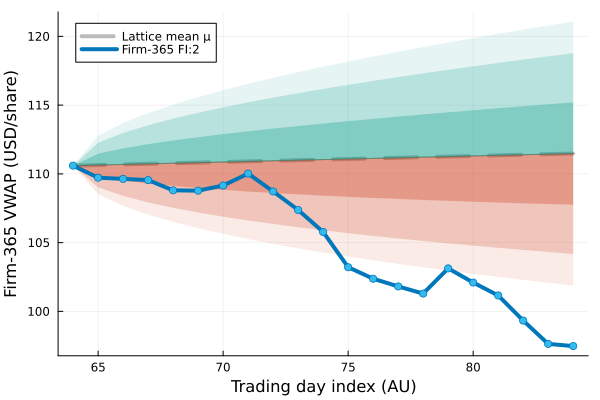

In [60]:
L68 = example_failed_sim[:,5]
U68 = example_failed_sim[:,6]
L95 = example_failed_sim[:,7]
U95 = example_failed_sim[:,8]
L99 = example_failed_sim[:,9]
U99 = example_failed_sim[:,10]

plot(example_failed_sim[:,1],example_failed_sim[:,3], c=colors[7], lw=4, label="Lattice mean μ", ls=:dash)
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L99, alpha=0.1, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U99, alpha=0.1, c=colors[6], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L95, alpha=0.2, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U95, alpha=0.2, c=colors[6], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L68, alpha=0.30, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U68, alpha=0.30, c=colors[6], label="")

plot!(example_failed_sim[:,1],example_failed_sim[:,2], c=colors[2], lw=4,label="Firm-$(firm_index) FI:$(failed_simulation_index)", legend=:topleft)
scatter!(example_failed_sim[:,1] ,example_failed_sim[:,2], msc=colors[2], mc=colors[3], label="")

xlabel!("Trading day index (AU)",fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)",fontsize=18)

#### Example succesful simulation
Likewise, we can also visualize successful simulations. For example, let's keep the same `firm_id` and select an example successful simulation index:

In [33]:
succesful_simulation_index = 20;
example_success_sim = successful_simulation_dict[firm_index][succesful_simulation_index]

Row,index,vwap,mean,sigma,L1,U1,L2,U2,L3,U3
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,484,136.025,136.025,0.0,136.025,136.025,136.025,136.025,136.025,136.025
2,485,137.312,136.079,1.01697,135.062,137.096,134.086,138.073,133.46,138.699
3,486,137.398,136.133,1.4388,134.694,137.572,133.313,138.953,132.427,139.84
4,487,136.561,136.187,1.76288,134.424,137.95,132.732,139.642,131.646,140.728
5,488,137.004,136.241,2.03644,134.205,138.278,132.25,140.233,130.995,141.487
6,489,137.271,136.295,2.27774,134.018,138.573,131.831,140.76,130.428,142.163
7,490,137.51,136.349,2.49617,133.853,138.846,131.457,141.242,129.919,142.779
8,491,136.991,136.403,2.69727,133.706,139.101,131.117,141.69,129.455,143.352
9,492,136.245,136.458,2.88469,133.573,139.342,130.804,142.112,129.027,143.888


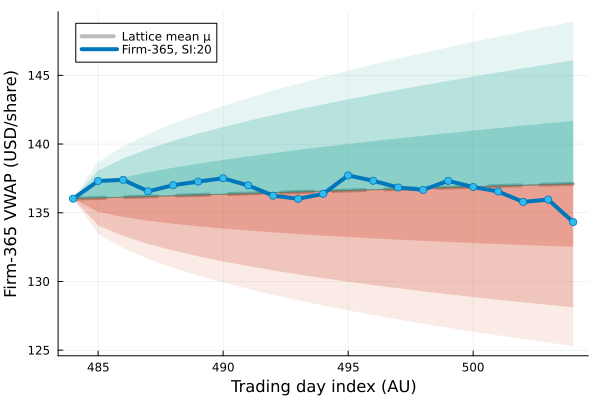

In [57]:
L68 = example_success_sim[:,5]
U68 = example_success_sim[:,6]
L95 = example_success_sim[:,7]
U95 = example_success_sim[:,8]
L99 = example_success_sim[:,9]
U99 = example_success_sim[:,10]

plot(example_success_sim[:,1],example_success_sim[:,3], c=colors[7], lw=4, label="Lattice mean μ", ls=:dash)
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L99, alpha=0.1, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U99, alpha=0.1, c=colors[6], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L95, alpha=0.2, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U95, alpha=0.2, c=colors[6], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L68, alpha=0.25, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U68, alpha=0.25, c=colors[6], label="")

plot!(example_success_sim[:,1],example_success_sim[:,2], c=colors[2], lw=4,label="Firm-$(firm_index), SI:$(succesful_simulation_index)", legend=:topleft)
scatter!(example_success_sim[:,1] ,example_success_sim[:,2], msc=colors[2], mc=colors[3], label="")
xlabel!("Trading day index (AU)",fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)",fontsize=18)

### Compute the probability of success $p_{+}$ for each firm
After analyzing the firms in both the `successful_simulation_dict` and `failed_simulation_dict`, it is evident that the lattice model has failed to predict share prices on at least one occasion for every firm in the `dataset`. To determine the likelihood of the lattice model succeeding, we examine the `successful_simulation_dict` data structure and estimate the probability that the lattice model can successfully predict equity prices: 

In [61]:
probability_dictionary = Dict{Int64, Float64}()
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    N₊ = successful_simulation_dict[firm_id] |> length    
    p₊ = N₊/number_of_date_ranges;
   
    probability_dictionary[firm_id] = p₊
end

#### Which firm was best described by the lattice model?

In [81]:
best_firm_value = 0.0;
best_firm_id = 0;
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    test_value = probability_dictionary[firm_id];
    if (test_value>best_firm_value)
        best_firm_value = test_value;
        best_firm_id = firm_id
    end
end

println("Best: Firm $(best_firm_id) had a success probability of p = $(best_firm_value)")

Best: Firm 85 had a success probability p = 0.8305084745762712


#### Which firm was worst described by the lattice model?

In [83]:
worst_firm_value = 10000.0;
worst_firm_id = 0;
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    test_value = probability_dictionary[firm_id];
    if (test_value<worst_firm_value)
        worst_firm_value = test_value;
        worst_firm_id = firm_id
    end
end

println("Worst: Firm $(worst_firm_id) had a success probability of p = $(worst_firm_value)")

Worst: Firm 124 had a success probability of p = 0.576271186440678
